### Comparation of 3 base models


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib


In [2]:
# run this cell to initiate the function, then the pipeline *should* run smoothly
from sklearn.preprocessing import FunctionTransformer

def clean_func(df):
    #
    import warnings # too lazy to fix this
    warnings.filterwarnings("ignore", message="Mean of empty slice")
    # Construction year
    df['construction_year'] = df['construction_year'].replace(0, np.nan)
    # Impute using region + installer
    df['construction_year'] = df.groupby(['region', 'installer'])['construction_year'].transform(
        lambda x: x.fillna(x.median())
    )
    #Impute using region only (for rows still missing)
    df['construction_year'] = df.groupby('region')['construction_year'].transform(
        lambda x: x.fillna(x.median())
    )
    #Use recorded year - 13
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['recorded_year'] = df['date_recorded'].dt.year
    df['construction_year'] = df['construction_year'].fillna(df['recorded_year'] - 13)
    #
    # gps_height 
    df['gps_height'] = df['gps_height'].apply(lambda x: np.nan if x <= 0 else x)
    # Fill using median per lga
    df['gps_height'] = df.groupby('lga')['gps_height'].fillna(df['gps_height'].median())
    # Fill any still missing using region median
    df['gps_height'] = df.groupby(['region'])['gps_height'].fillna(df['gps_height'].median())
    # Longitude and latitude
    df['longitude'] = df['longitude'].replace(0, np.nan)
    df['latitude'] = df['latitude'].where(df['latitude'] < -0.5, np.nan) # too close to the equator
    for i in ['latitude','longitude']: # loop to fill by lga, region
        df[i] = df.groupby(['lga'])[i].fillna(df[i].median())
        df[i] = df.groupby(['region'])[i].fillna(df[i].median())
    # population
    # Fill population using median by district_code
    df['population'] = df.groupby('lga')['population'].transform(
        lambda x: x.fillna(x.median())
    )
    # Fill any still missing with median by region, then overall median
    df['population'] = df.groupby('region')['population'].transform(
        lambda x: x.fillna(x.median())
    )
    df['population'] = df['population'].fillna(df.population.median)
    # Bin the outcome, see how it behaves
    df['population'] = pd.cut(df['population'], [-1,1,25,90,160,260,9999999], labels=[0,0.2,0.3,0.4,0.6,1])
    df['population'] = df['population'].astype(float)
    #
    # amount_tsh
    df['amount_tsh'] = df['amount_tsh'].apply(lambda x: min(x, 15000))
    df['amount_tsh'] = df['amount_tsh'].apply(lambda x: np.power(x,0.3))
        ### Encode categorical variables
    # Encode 'quantity' (and typo fix: 'insufficent' -> 'insufficient')
    df['quantity'] = df['quantity'].replace({
        'enough': 1,
        'seasonal': 0.6,
        'insufficient': 0.4,
        'dry': 0,
        'unknown': 0
    })
    df.quantity = pd.to_numeric(df.quantity, errors='coerce')

    # Encode 'water_quality' as binary: good = 1, else 0
    df['water_quality'] = np.where(df['water_quality'] == 'soft', 1, 0)
    # Encode 'waterpoint_type' (1 = preferred type, 0 = everything else)
    preferred_waterpoint = ['communal standpipe multiple', 'communal standpipe']
    df['waterpoint_type'] = df['waterpoint_type'].apply(lambda x: 1 if x in preferred_waterpoint else 0)
    # Encode 'permit' as binary: True = 1, False, missing = 0
    df['permit'] = np.where(df['permit'] == 'True', 1, 0)
    # Encode 'payment' as binary: never pay = 0, else = 1
    df['payment'] = np.where(df['payment'] == 'never pay', 0, 1)
    # Encode 'source' (1 = preferred sources, 0 = everything else)
    preferred_sources = ['spring', 'river', 'rainwater harvesting']
    df['source'] = df['source'].apply(lambda x: 1 if x in preferred_sources else 0)
    # Encode 'payment' as binary: never pay = 0, else = 1
    df['extraction_type_class'] = np.where(df['extraction_type_class'] == 'gravity', 0, 1)
    # Encode 'scheme_management' (1 = VWC, others 0)
    df['scheme_management'] = np.where(df['scheme_management'] == 'VWC', 0, 1)
    # one hot encoder for basin 
    df = pd.get_dummies(data=df, columns=['basin'], drop_first=True, dtype=int) 
    df = df.drop(columns=['id',  'date_recorded', 'funder', 'installer', 'wpt_name', 'num_private',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'waterpoint_type_group',
       'ward', 'public_meeting', 'recorded_by', 'scheme_name', 'extraction_type', 'recorded_year',
       'extraction_type_group', 'management', 'management_group', 'payment_type',
       'quality_group', 'quantity_group', 'source_type', 'source_class'])
    df['tshXpayment'] = df.amount_tsh * df.payment
    df['extractXsource'] = df.extraction_type_class * df.source
    df['popXtsh'] = df.population * df.amount_tsh
    df['popXquant'] = df.population * df.quantity
    df['popXsource'] = df.population * df.source
    df['extractXheight'] = df.extraction_type_class * df.gps_height
    df['typeXsource'] = df.waterpoint_type * df.source
    df['typeXyear'] = df.waterpoint_type * df.construction_year
    df['yearXpop'] = df.construction_year * df.population
    df['quantXsource'] = df.quantity * df.source
    df['yearsq'] = np.sqrt(df.construction_year + 1)
    
    return df


print('ready for piping')

my_transformer = FunctionTransformer(clean_func) # still can't get this to work in the pipeline with the clf gris search


import warnings
warnings.filterwarnings("ignore", message="Mean of empty slice")

ready for piping


In [4]:
# set paths
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_path = os.path.join(parent_dir, 'data')
out_path = os.path.join(parent_dir, 'outputs')

# Read the files
le = LabelEncoder()
train = pd.read_csv(os.path.join(data_path, 'train.csv'))
labels = pd.read_csv(os.path.join(data_path, 'train_labels.csv')) 
y = le.fit_transform(labels['status_group']) 

# for now, cleaning and scaling before the pipeline
scaler = MinMaxScaler()
cleaned_X = clean_func(train)
model = scaler.fit(cleaned_X)
X = model.transform(cleaned_X)


# scale features
#scaler = MinMaxScaler()
#model=scaler.fit(data)
#scaled_data=model.transform(data)

# Define features and target = y_encoded
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


/tmp/ipykernel_10556/3981372757.py:26: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df['gps_height'] = df.groupby('lga')['gps_height'].fillna(df['gps_height'].median())
/tmp/ipykernel_10556/3981372757.py:28: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df['gps_height'] = df.groupby(['region'])['gps_height'].fillna(df['gps_height'].median())
/tmp/ipykernel_10556/3981372757.py:33: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df[i] = df.g

In [12]:
# the big show - I'd like to play more with parameters, but I think we're out of time

from xgboost import XGBClassifier 
xgboost = XGBClassifier(objective='multi:softprob', eval_metric='auc', num_class=3)



my_transformer = FunctionTransformer(clean_func)

clf = GridSearchCV(
    xgboost,
    {'objective': ['multiclass'],
    'eval_metric': ['auc'], 
    'nthread': [-1],
    'min_child_weight': [0.5, 0.75, 1, 1.5],
    'num_class': [3],
    'gamma': [0, 0.15, 0.3, 0.5], # gamma
    'max_delta_step': [0.5, 0.75, 1], 
    'learning_rate': [0.3, 0.35, 0.4], # eta
    'max_depth': [7,  8],
#    'n_estimators': [100, 200],
#    'subsample': [0.8, 1.0],
#    'colsample_bytree': [0.8, 1.0]
    },
    verbose=1,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc_ovr',
) 

# Grid search
#grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)


best_model = clf.best_estimator_



# Check best_estimator_
print(" Type:", type(clf))
print(" Best Estimator:", clf.best_estimator_)




Fitting 5 folds for each of 288 candidates, totalling 1440 fits
0.8709819607829135
{'eval_metric': 'auc', 'gamma': 0, 'learning_rate': 0.3, 'max_delta_step': 1, 'max_depth': 8, 'min_child_weight': 1, 'nthread': -1, 'num_class': 3, 'objective': 'multiclass'}
 Type: <class 'sklearn.model_selection._search.GridSearchCV'>
 Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=1, max_depth=8,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_stra

In [13]:
 
# Check best_estimator_
print(" Type:", type(clf))
print(" Best Estimator:", clf.best_estimator_)

# Evaluate on X_test
y_pred = clf.predict(X_test)
print(" Classification Report on Test Set:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

 Type: <class 'sklearn.model_selection._search.GridSearchCV'>
 Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=1, max_depth=8,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, nthread=-1, ...)
 Classification Report on Test Set:
                         precision    recall  f1-score   support

             functional       0.77      0.88      0.82      9678
functional needs 

In [103]:
 
# Check best_estimator_
print(" Type:", type(clf))
print(" Best Estimator:", clf.best_estimator_)

# Evaluate on X_test
y_pred = clf.predict(X_test)
print(" Classification Report on Test Set:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


 Type: <class 'sklearn.model_selection._search.GridSearchCV'>
 Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=1, max_depth=8,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, nthread=-1, ...)
 Classification Report on Test Set:
                         precision    recall  f1-score   support

             functional       0.77      0.88      0.82      9678
functional needs 

Best Parameters Found:
{'eval_metric': 'auc', 'gamma': 0, 'learning_rate': 0.3, 'max_delta_step': 1, 'max_depth': 8, 'min_child_weight': 1, 'nthread': -1, 'num_class': 3, 'objective': 'multiclass'}


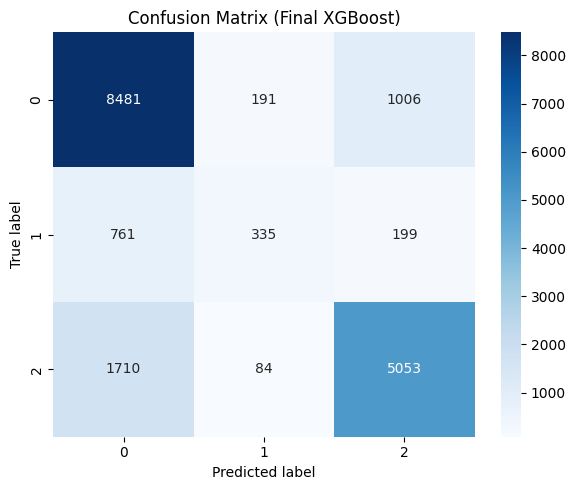

<Figure size 640x480 with 0 Axes>

In [109]:
# like most above, this is from Fatemeh

print("Best Parameters Found:")
print(clf.best_params_)
 

# confusion matrix (rows=true, cols=predicted)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues", 
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Final XGBoost)")
plt.tight_layout()
plt.show()

# Save the figure
plt.savefig(os.path.join(out_path, "confusion_mat.png"), dpi=300, bbox_inches='tight')


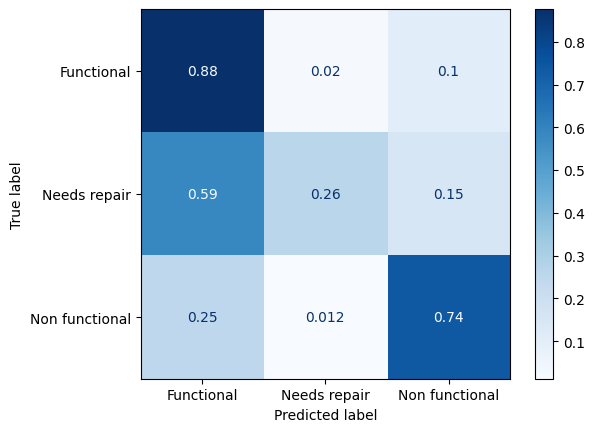

In [120]:
# another version
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
    clf.best_estimator_,
    X_test,
    y_test,
    display_labels=['Functional','Needs repair', 'Non functional'],
    cmap=plt.cm.Blues,
    normalize='true'
)

plt.savefig(os.path.join(out_path, "confusion_mat.png"), dpi=300, bbox_inches='tight')

(31, 1)

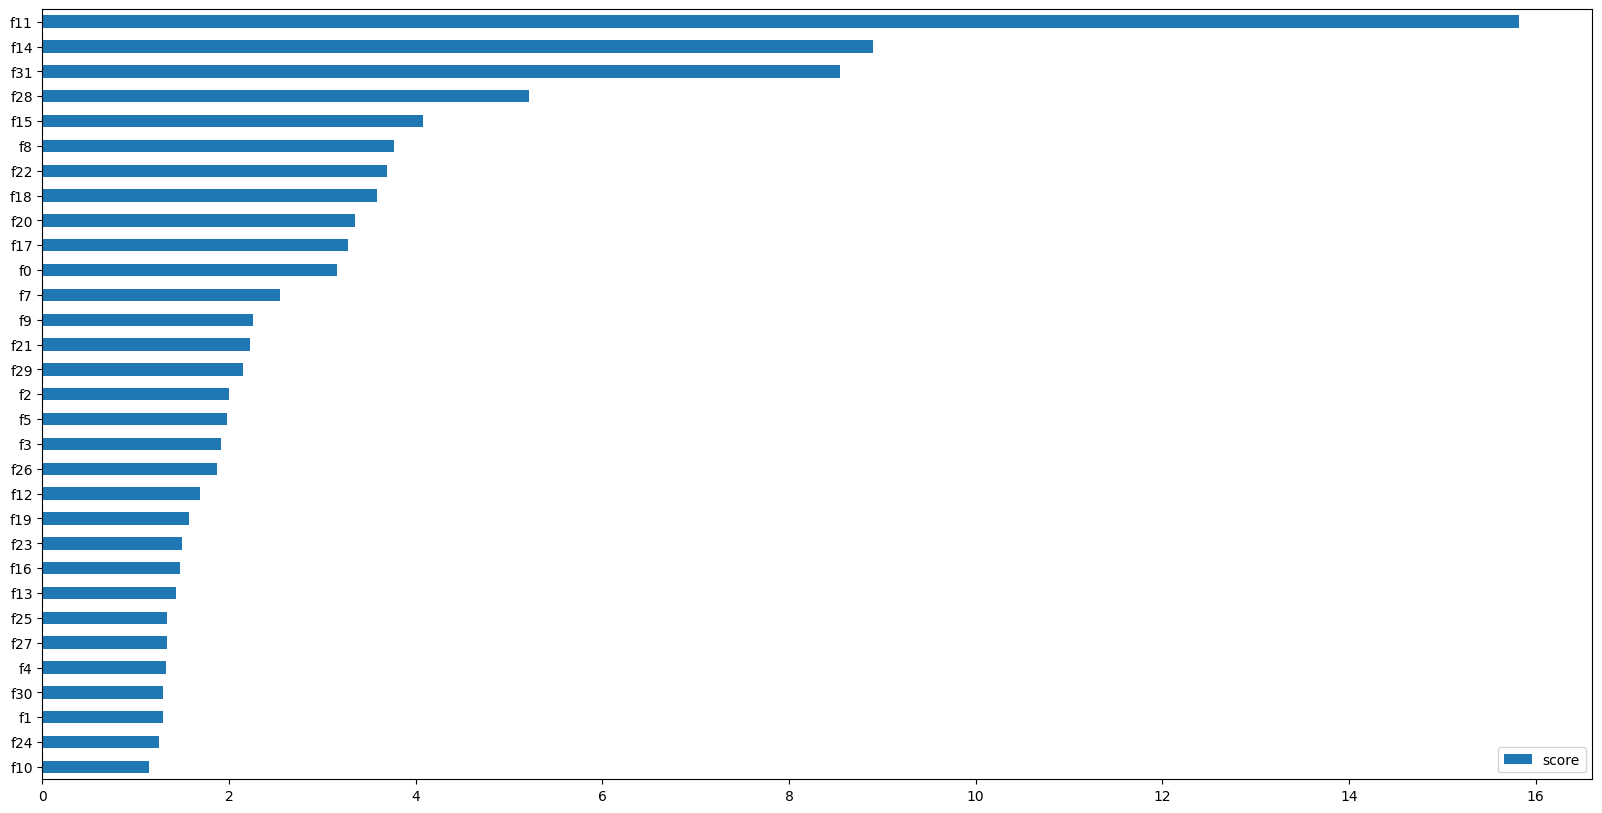

In [60]:
# new, stolen from substack, a bit of feature imporance. Try other importance_type options for more

feature_important = clf.best_estimator_.get_booster().get_score(importance_type='gain') # gain, weight, cover, total_gain, total_cover
keys = list(feature_important.keys())
values = list(feature_important.values())
df = pd.DataFrame(keys, values)


data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh', figsize = (20,10))
df.shape

In [58]:
clf.best_estimator_.get_booster().get_split_value_histogram('construction_year')

,SplitValue,Count


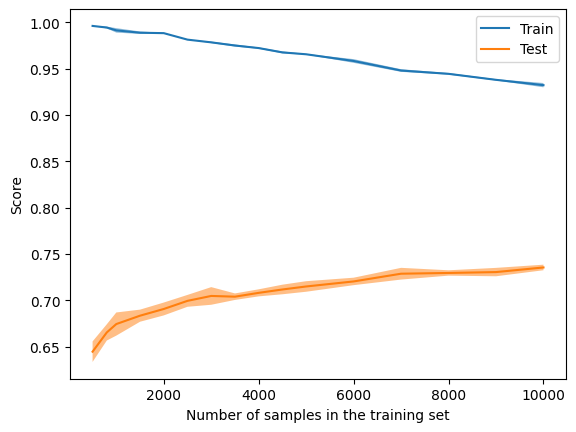

In [98]:
# curves??
from sklearn.model_selection import LearningCurveDisplay
from sklearn.utils import shuffle

X, y = shuffle(X_train, y_train, random_state=42)
fig2 = LearningCurveDisplay.from_estimator(
   clf.best_estimator_, X, y, train_sizes=[500, 800, 1000, 1500,2000,2500,3000,3500,4000,4500,5000,6000,7000,8000,9000,10000], cv=5) 

plt.savefig(os.path.join(out_path, "learning_curve.png"), dpi=300, bbox_inches='tight')


In [59]:
explainer = shap.KernelExplainer(clf.best_estimator_.predict, shap.sample(X_train,100))

In [60]:
shap_values = explainer.shap_values(X_test,nsamples=100)

  0%|          | 0/17820 [00:00<?, ?it/s]

/tmp/ipykernel_10556/1704076162.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,X_test, feature_names=features, show=False)


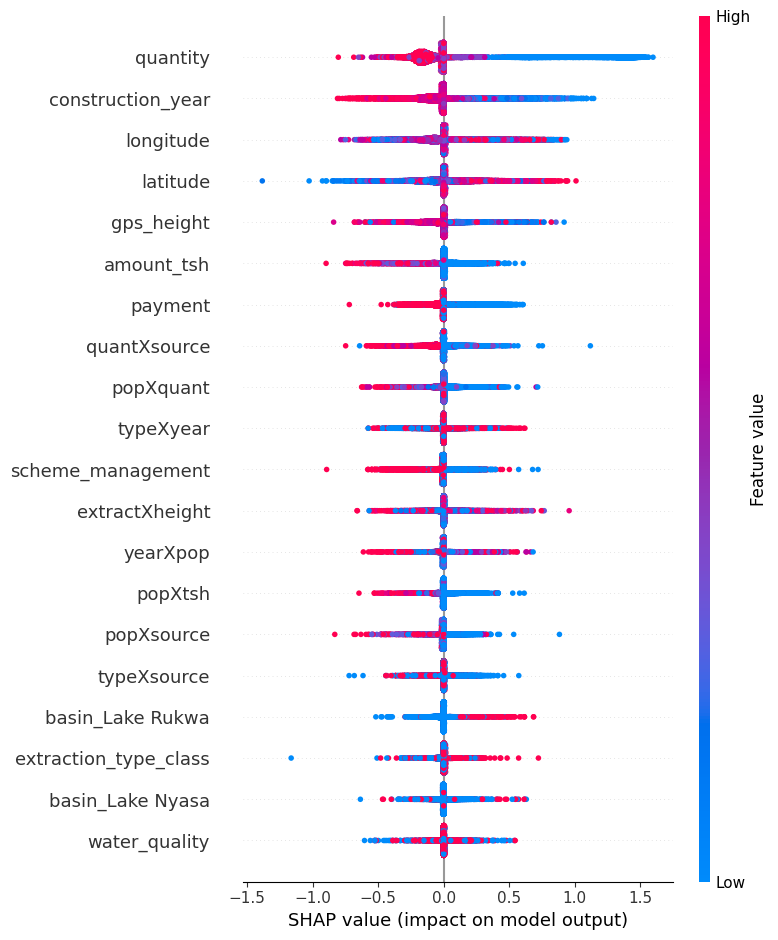

In [123]:
# try this if shap ever works
features = cleaned_X.columns

shap.plots.initjs()


shap.summary_plot(shap_values,X_test, feature_names=features, show=False) # show=False necessary to save figure

plt.savefig(os.path.join(out_path, "shap_summary.png"), dpi=300, bbox_inches='tight')


In [96]:
# force plot, for a single observation from X_train
shap.force_plot(explainer.expected_value, shap_values[0,:]  ,X_train[2,:],feature_names=features, show=False)
# plt.savefig(os.path.join(out_path, "shap_force_plot.png"), dpi=300, bbox_inches='tight')

/tmp/ipykernel_10556/3598218678.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=features, max_display=12, show=False)


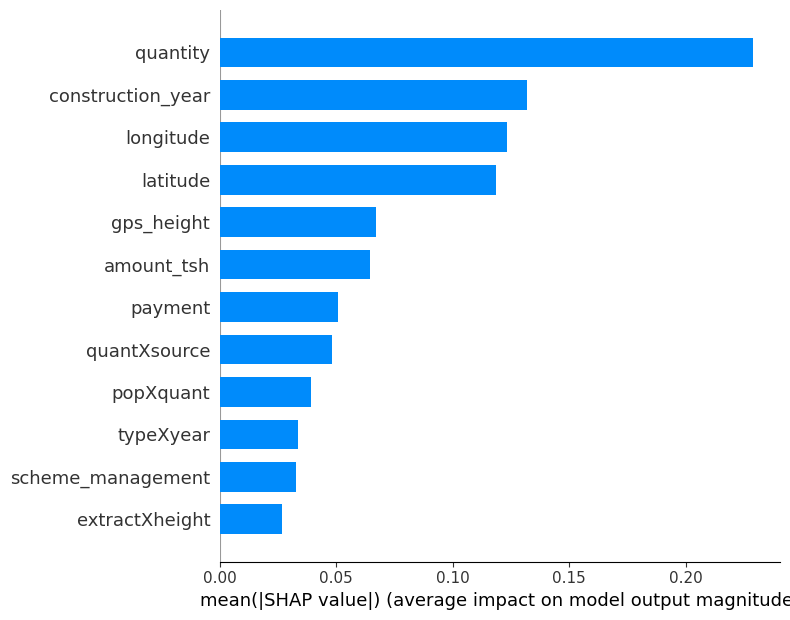

In [126]:
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=features, max_display=12, show=False)

plt.savefig(os.path.join(out_path, "shap_bar.png"), dpi=300)

In [31]:
# predict the final on the main data
y_all = clf.predict(X)
y_out = pd.DataFrame(le.inverse_transform(y_all))
train['status_group'] = y_out
train.to_csv(os.path.join(data_path, 'predicted.csv'), index=False, columns=['id','status_group'])

In [101]:
cleaned_X.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population',
       'scheme_management', 'permit', 'construction_year',
       'extraction_type_class', 'payment', 'water_quality', 'quantity',
       'source', 'waterpoint_type', 'basin_Lake Nyasa', 'basin_Lake Rukwa',
       'basin_Lake Tanganyika', 'basin_Lake Victoria', 'basin_Pangani',
       'basin_Rufiji', 'basin_Ruvuma / Southern Coast', 'basin_Wami / Ruvu',
       'tshXpayment', 'extractXsource', 'popXtsh', 'popXquant', 'popXsource',
       'extractXheight', 'typeXsource', 'typeXyear', 'yearXpop',
       'quantXsource', 'yearsq'],
      dtype='object')